In [1]:
import numpy as np
import pandas as pd
import utm
import shapely as shp
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#### Projecting Lat Long into a planner map

In [2]:
# Using the UTM package 
# for lat,lon in 
# Note: utm function takes input param1:latitude, param2:longitude
print (utm.from_latlon(11.1, -80.2))
print (utm.from_latlon(11.1345, -80.11))
print (utm.from_latlon(11.2, -81.0))

# Using Geopandas:
dataIN = pd.DataFrame({'longitude': [-80.2, -80.11, -81.0], 'latitude': [11.1, 11.1345, 11.2]})
dataIN
s = gpd.GeoSeries([Point(x,y) for x, y in zip(dataIN['longitude'], dataIN['latitude'])])
s
geo_df = gpd.GeoDataFrame(geometry=s)   # Is Similar to doing SpatialDataFrame in R
geo_df
geo_df.crs = {'init': 'epsg:4326'}      # Initialize what type of CRS 

geo_df = geo_df.to_crs({'init': 'epsg:3395'}) # Convert into a new CRS, similar to doing 
geo_df
# The Equivallent R code for the above function would be :
# out <- spTransform(dataIN_Spatial_DF, CRS=CRS("+init=epsg:3395 +proj=merc +ellps=WGS84"))

(587368.1295072659, 1227153.9499450792, 17, 'P')
(597186.3160143532, 1230997.0010059343, 17, 'P')
(500000.0, 1238093.672948581, 17, 'P')


geometry
0   POINT (-8927823.161620541 1235228.11420853)
1   POINT (-8917804.407449147 1239116.84994171)
2  POINT (-9016878.754255159 1246501.097746004)

## Manipulating Data Frames and Plotting with GeoPandas:
----------

#### Part-1: Shape Plots (Polygon Data):

(177, 6)
       continent  gdp_md_est  \
0           Asia     22270.0   
1         Africa    110300.0   
2         Europe     21810.0   
3           Asia    184300.0   
4  South America    573900.0   

                                            geometry iso_a3  \
0  POLYGON ((61.21081709172574 35.65007233330923,...    AFG   
1  (POLYGON ((16.32652835456705 -5.87747039146621...    AGO   
2  POLYGON ((20.59024743010491 41.85540416113361,...    ALB   
3  POLYGON ((51.57951867046327 24.24549713795111,...    ARE   
4  (POLYGON ((-65.50000000000003 -55.199999999999...    ARG   

                   name     pop_est  
0           Afghanistan  28400000.0  
1                Angola  12799293.0  
2               Albania   3639453.0  
3  United Arab Emirates   4798491.0  
4             Argentina  40913584.0  


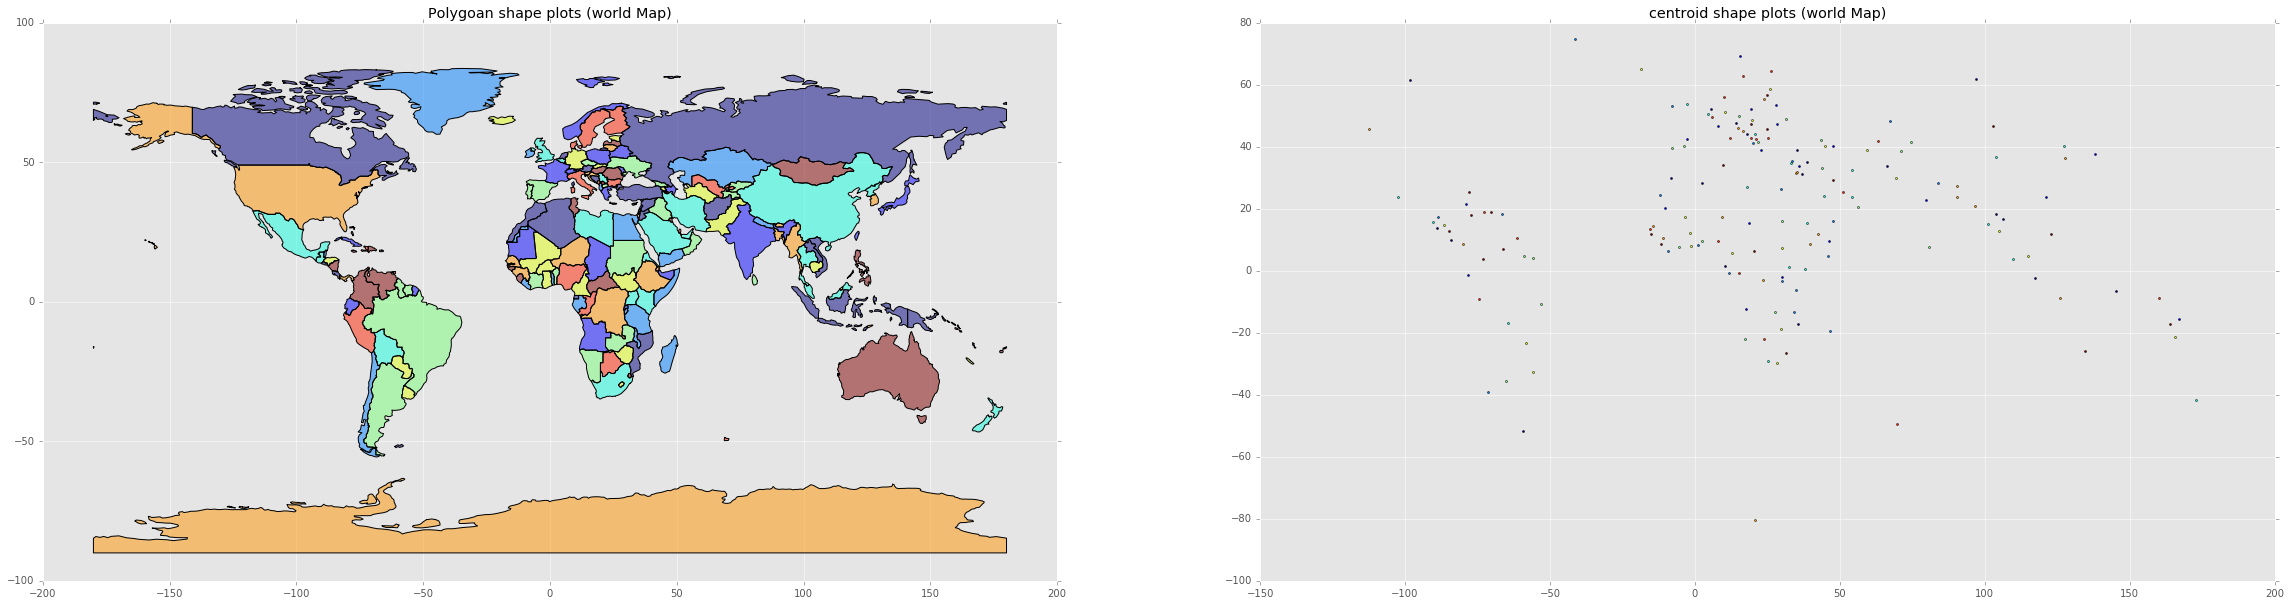

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print (world.shape)
print (world.head())

# To get the name of the coordinate column
world.geometry.name

# Set a Frame for the plot
fig, ax = plt.subplots(1,2, figsize=(40,10))

# To rename the column to boder instead of geometry and then set it as the coordinate/geometry column
world = world.rename(columns={"geometry": "borders"}).set_geometry('borders')
world.plot(ax=ax[0])
ax[0].set_title('Polygoan shape plots (world Map)')

# Now that our column "borders" is defined as the geometry column, we can do all
# geopandas operations on the Dataframe and only the border column will be affected by it.

# Lets us create a new column "centroid" that finds the center point of the polygoan area
world["centroid"] = world.centroid
# We have to set the centroid column as geometry to perform geopandas operations
world = world.set_geometry('centroid')
world.plot(ax=ax[1])
ax[1].set_title('centroid shape plots (world Map)')

#### **A Choropleth map : **

A choropleth map is a thematic map (with a certain theme) in which are are shaded or patterend in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per capita income.

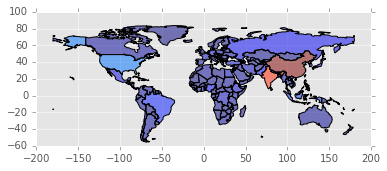

In [4]:
# Now we plot a map where the regions are colored based on the population residing at that part.
worldNew = world[(world.pop_est > 0) & (world.name != 'Antarctica')]
# Setting the geometry column again to borders for the new dataFrame to avoid centroid plots every time
worldNew = worldNew.rename(columns={"geometry": "borders"}).set_geometry('borders')
worldNew.plot(column='pop_est')

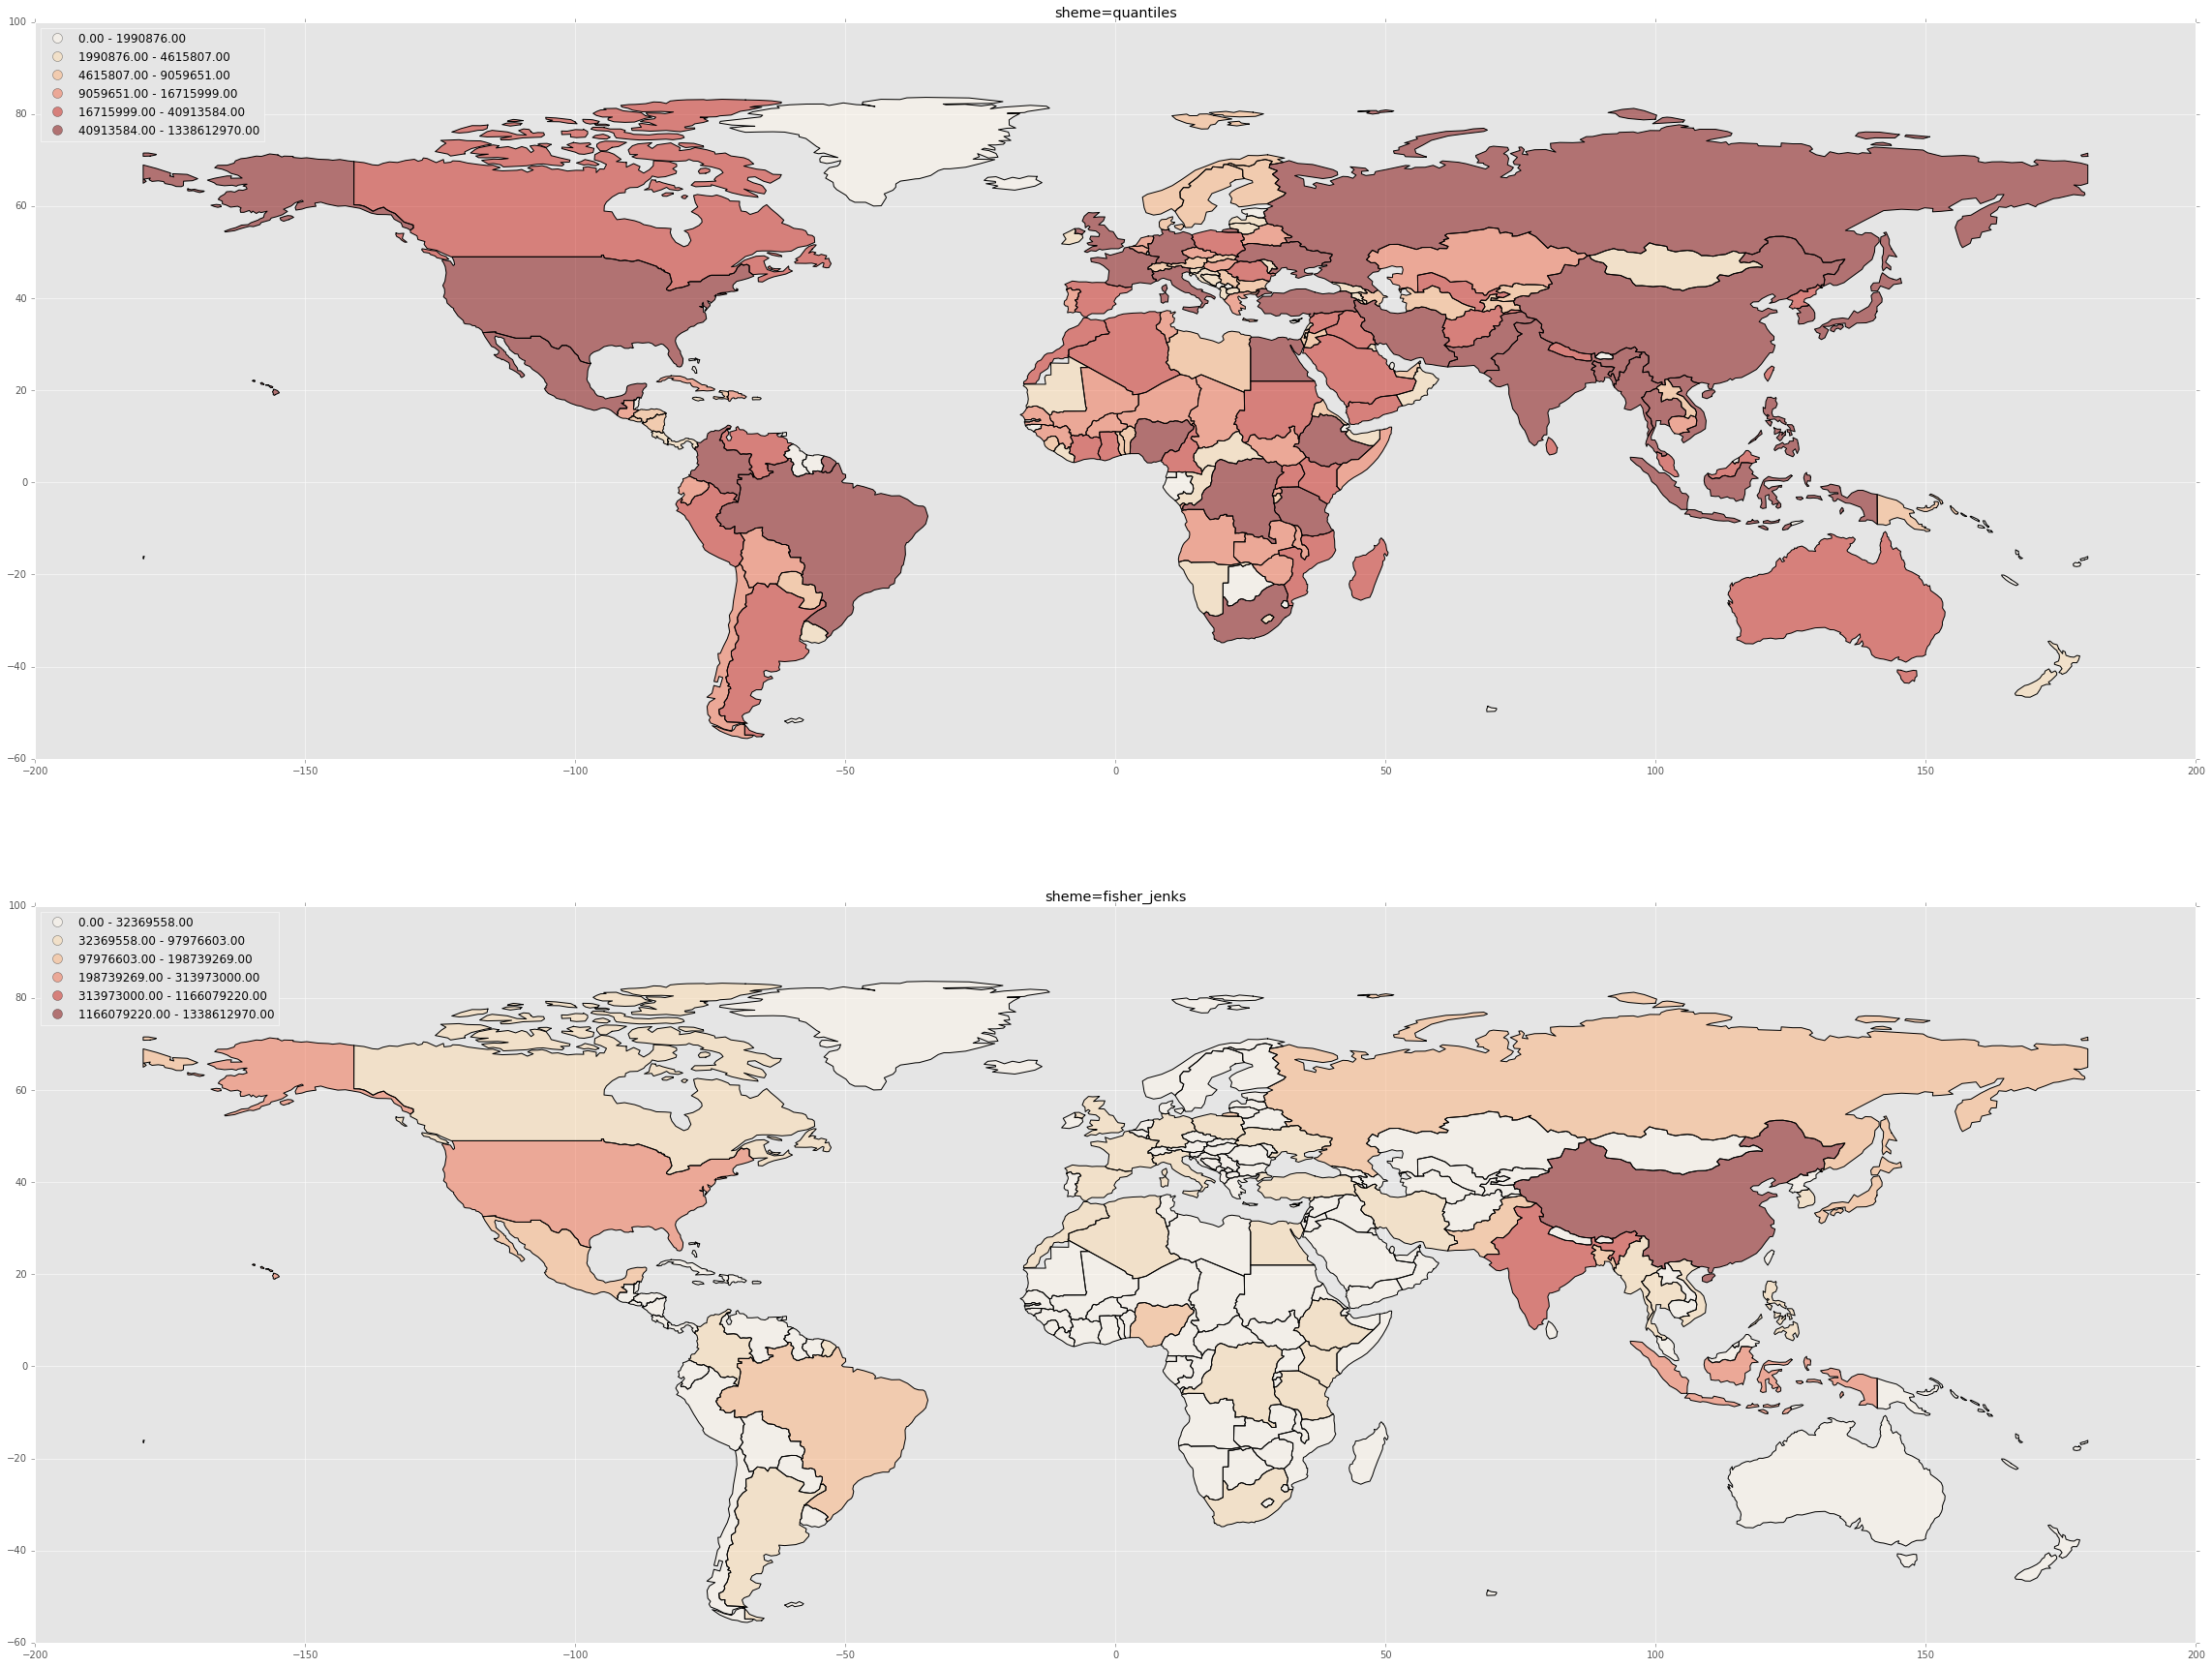

In [5]:
kw = dict(column='pop_est', k=6, cmap='OrRd')

fig, ax = plt.subplots(2,1, figsize=(40,30))
worldNew.plot(ax=ax[0], scheme='quantiles', **kw, legend=True); 
worldNew.plot(ax=ax[1], scheme='fisher_jenks', **kw, legend=True);
# A classification scheme is the product of arranging things
# into kinds of things (classes) or into groups of classes

leg0 = ax[0].get_legend()
leg0.set_bbox_to_anchor((0, 0, 1, 1))  # (left, bottom, width, height)
ax[0].set_title('sheme=quantiles')

leg1 = ax[1].get_legend()
leg1.set_bbox_to_anchor((0, 0, 1, 1))
ax[1].set_title('sheme=fisher_jenks')

#### Part-2: Point Plot (Lat, Long):

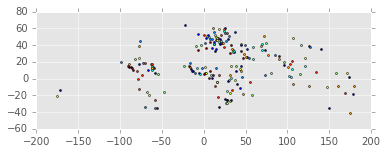

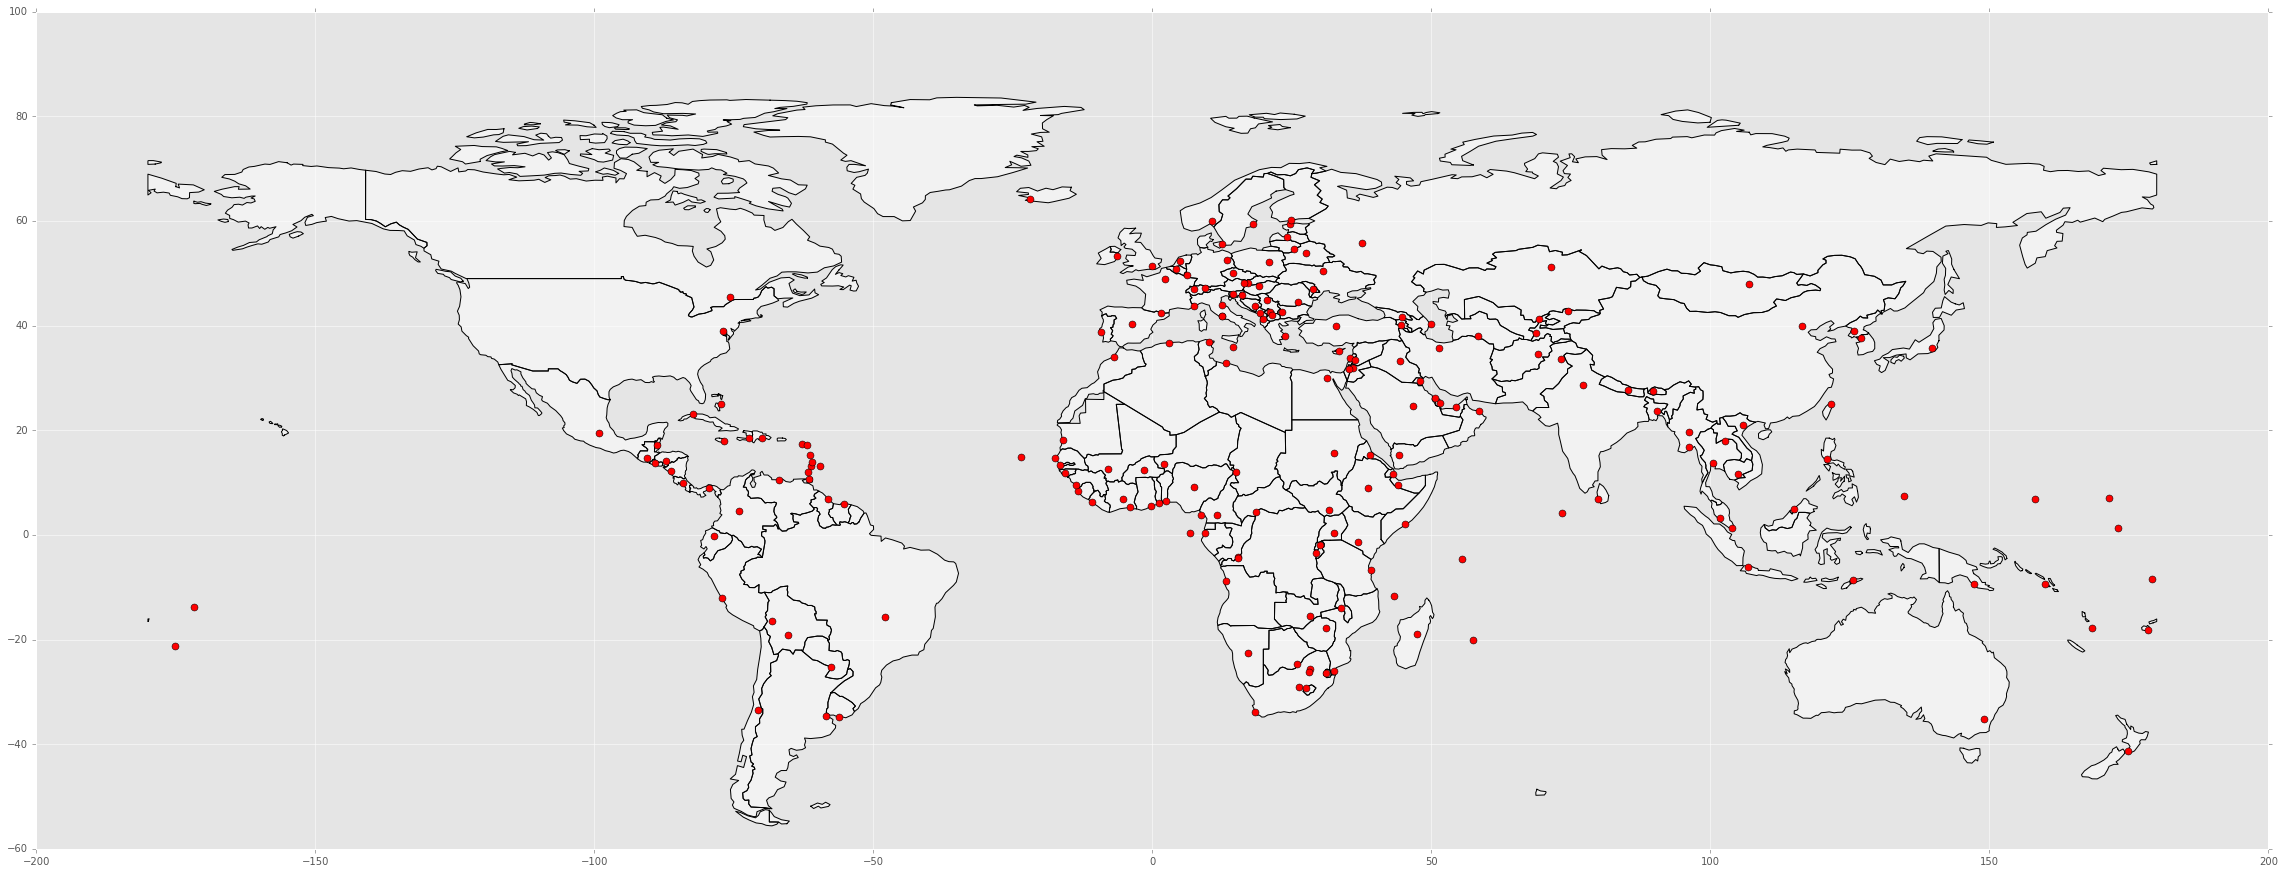

In [6]:
# Get the latitude and longitude data for the 
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities.head()

# Renaming the geometry column to latlong
cities = cities.rename(columns={'geometry' : 'latlong'}).set_geometry('latlong')
cities.plot()

# This aint that of a very good plot, 
# Let us now plot the points on top of the world map

# Step 1: Set a figure
fig, ax = plt.subplots(1,1, figsize=(40,15))

# Step 1: Set a base plot
basePlot = worldNew.plot(ax=ax, color='white') # we give white color so that the points are easily visible on the world map

# Step 2: Plot the points on top of the base plot
newPlot = cities.plot(ax=basePlot, marker='o', color='red', markersize=7)
# ax.set_title('Point plot on top of polygoan shape plots')

## Projections with GeoPandas:
------------

CSR type for the world map :  {'init': 'epsg:4326'}


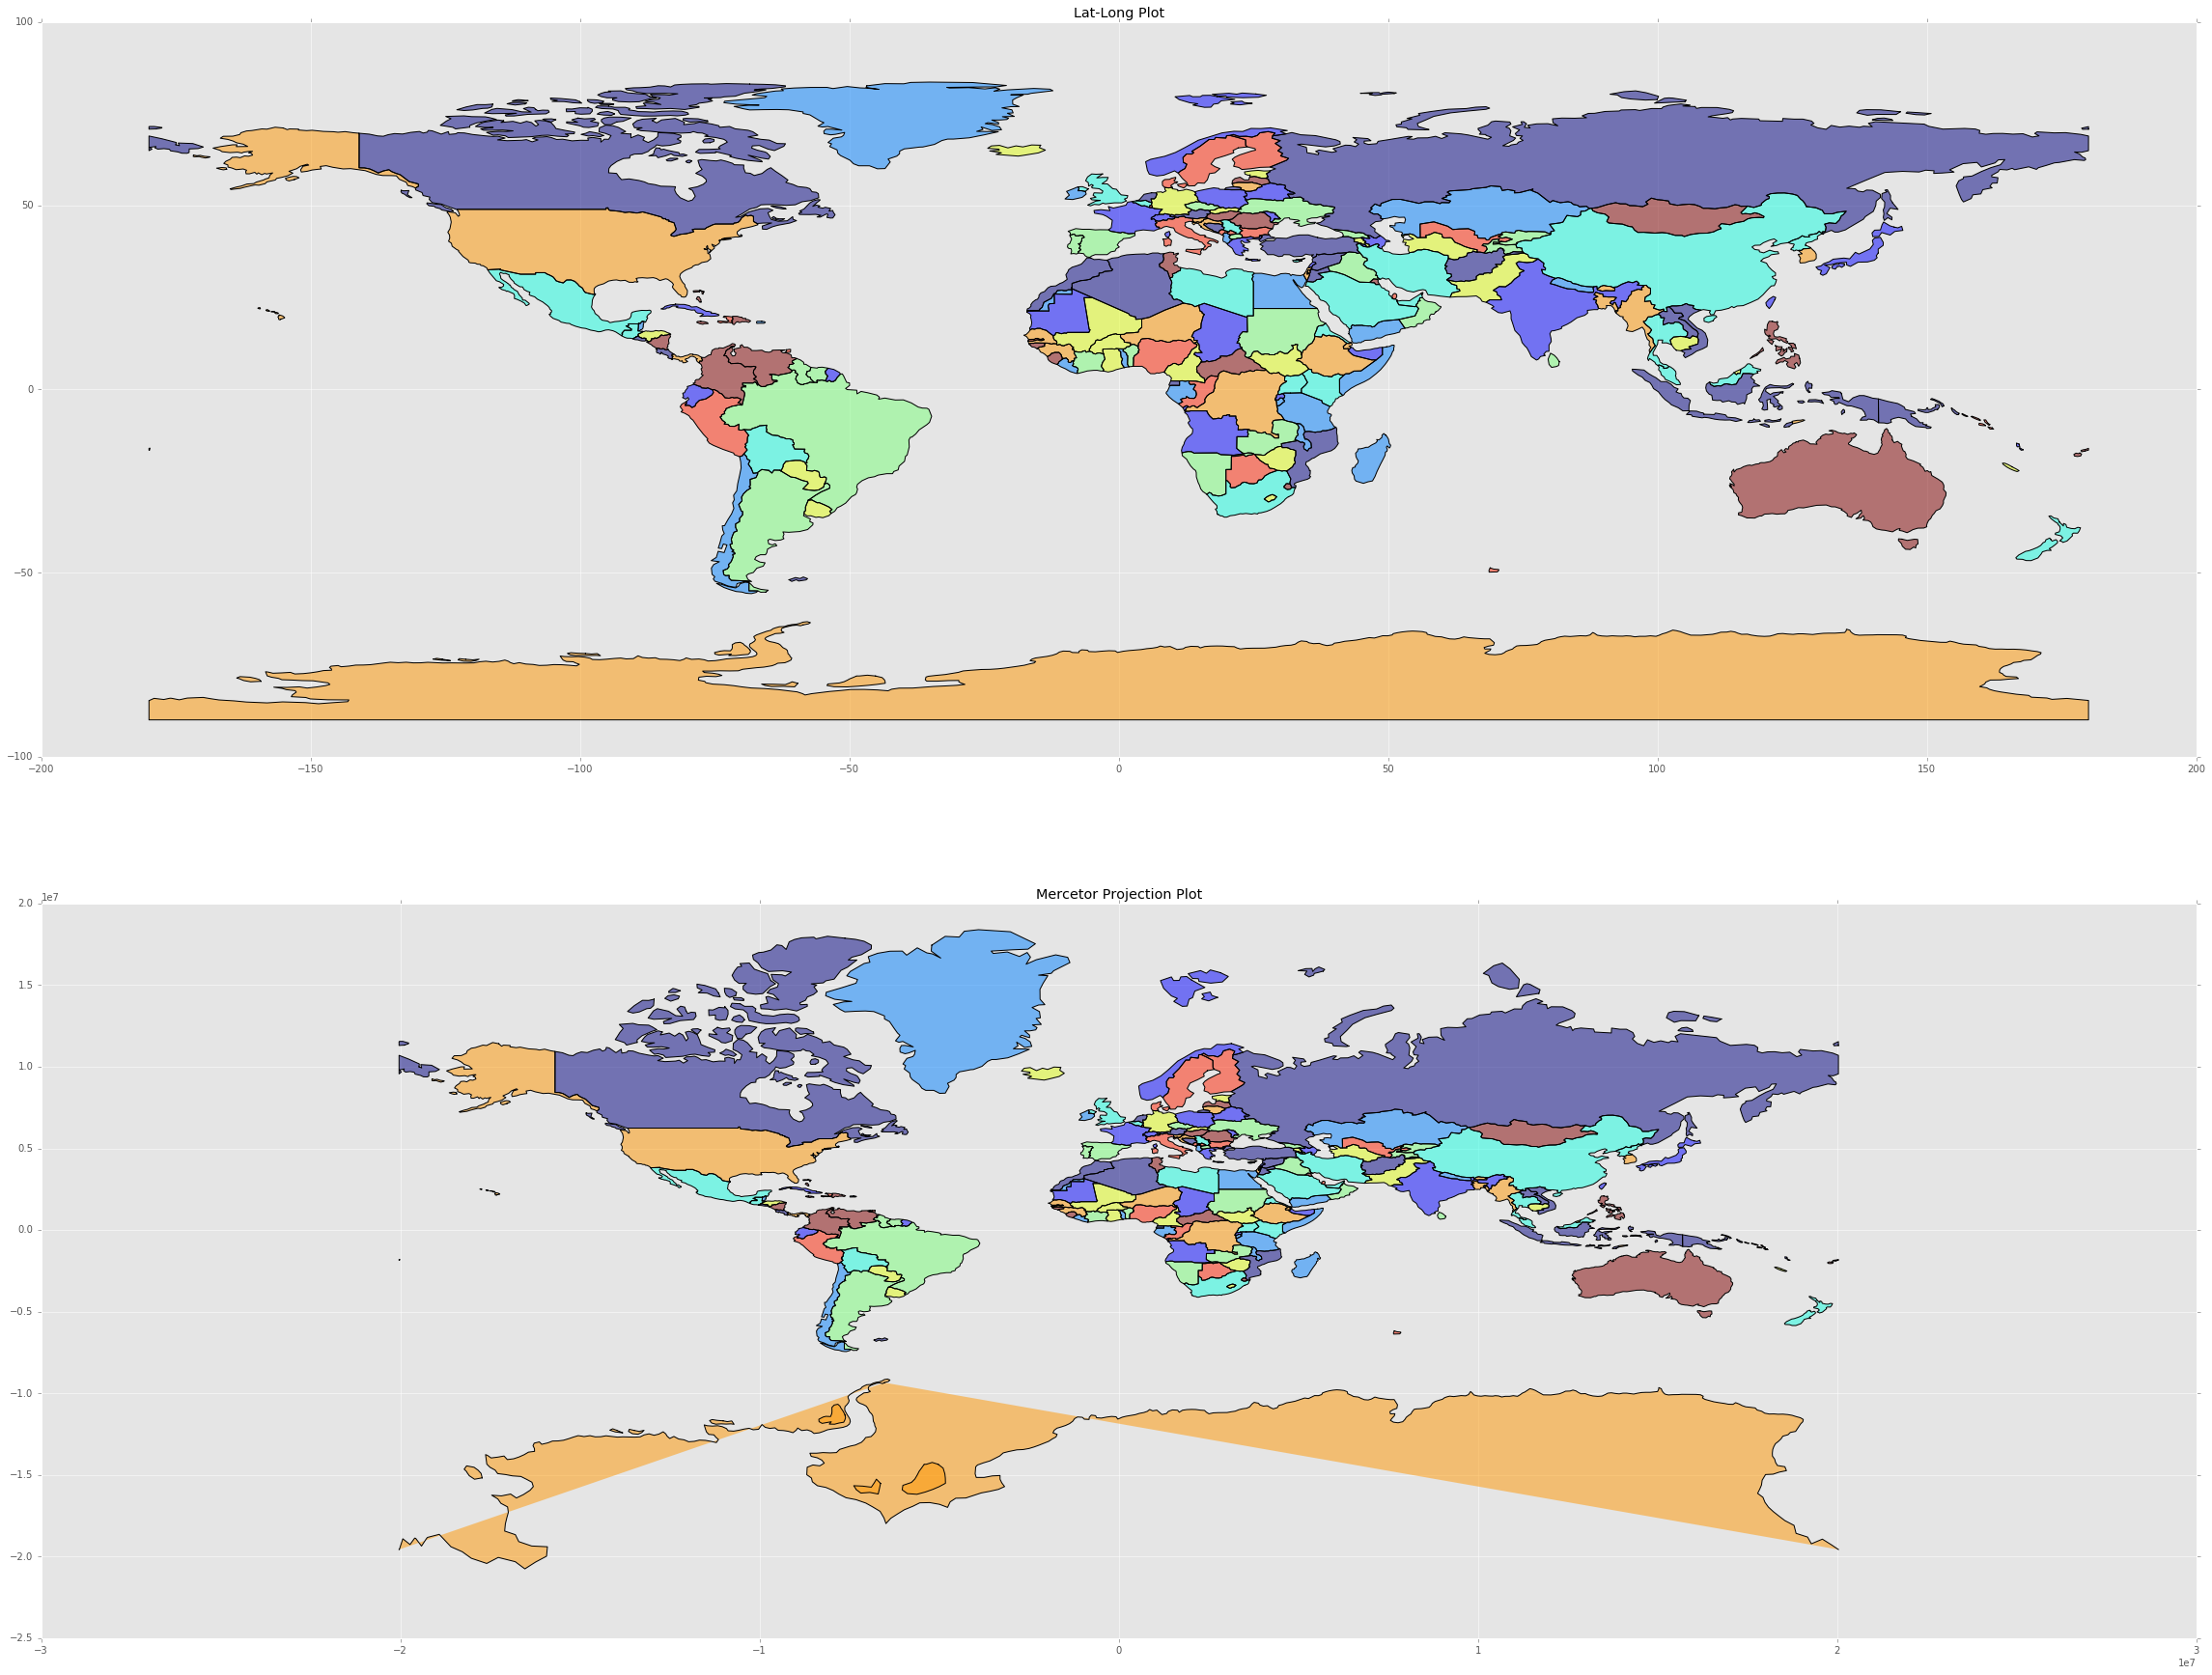

In [7]:
# Reload the data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Check the Type of Coordiante reference system (CRS)
csrType = world.crs
print ('CSR type for the world map : ', csrType)

# We see that the polygoans points are of EPSG:4326 which is latitude and longitude coordinate system
# Now we reproject them to Mercator (in Km). basically we project the latlong points onto a plane
world_merc = world.to_crs({'init': 'epsg:3395'})

# Plot both the projections (latlong and mercetor)
fig, ax = plt.subplots(2,1, figsize=(40,30))
world.plot(ax=ax[0])
world_merc.plot(ax=ax[1])
ax[0].set_title('Lat-Long Plot')
ax[1].set_title('Mercetor Projection Plot')

## Geometric Manipulation:
----------

The GeoPandas API provides all different types of geometric manipulation provided by the ***shapely library***. Some of them are given as :
  * Points (methods : {area, bounds, coords})
  * LineString (methods : {bounds, coords})
  * LineRing (methods : {area, length, bounds, coords})
  * Polygoans (methods : {area, length, bounds, coords})
  * MultiPoint (methods : {area, length, bounds, coords})
  * Other manipulations : intersection, union, centroid, difference etc.......

GeoPandas invokes two Classes where we can combine different shapes and put it into a Data Frame.

 * GeoSeries
 * GeoDataFrame

#### GeoSeries:

In many application we wont get inputs as shapes but list of coordinate points, GeoSeries helps to convert such coordinates into shapes that are inderstood by GeoPandas and hence can be manipulated using all the methods of **Shapely**

In [8]:
# A simple Geometric projection
# First we define few polygoans

p1 = shp.geometry.Polygon([(0, 0), (1, 0), (1, 1)])
p2 = shp.geometry.Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = shp.geometry.Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])

# Now we create a Geometric Series using goepandas
gs = gpd.GeoSeries([p1,p2,p3])
print (gs)

# Now that gs is a GeoSeries object we can use all the relevant methods/variables 
# provided by the shapely library to manipulate the polygons shape
print ('The area each polygons is:\n', gs.area)
print ('The length each polygons is:\n',gs.length)
print ('The centroids of each polygons are:\n', gs.centroid)
print ('The convex_hull of each polygons are:\n', gs.convex_hull)
# gs.plot()

0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object
The area each polygons is:
 0    0.5
1    1.0
2    1.0
dtype: float64
The length each polygons is:
 0    3.414214
1    4.000000
2    4.000000
dtype: float64
The centroids of each polygons are:
 0    POINT (0.6666666666666666 0.3333333333333333)
1                                  POINT (0.5 0.5)
2                                  POINT (2.5 0.5)
dtype: object
The convex_hull of each polygons are:
 0         POLYGON ((0 0, 1 1, 1 0, 0 0))
1    POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))
2    POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))
dtype: object


#### GeoDataFrame:

GeoDataFrames helps in many ways, 1) It says GeoPandas that a particular Series or Input is a GeoDataFrame, so that one input column can be treated as the geometry column and all **GeoPandas/Shapely** operation can be done on the column. 2) When we load a dataset from disk it is always good to store the input in a DataFrame so that we can perform all small sql like manipulations we desire.

In [9]:
# First let us load a data from disk and put it into a GeoDataFrame
dataDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/tl_2015_48_tract/tl_2015_48_tract.shp'
tl_2015 = gpd.GeoDataFrame.from_file(dataDir)
tl_2015.head()

ALAND   AWATER COUNTYFP FUNCSTAT        GEOID     INTPTLAT  \
0   5956745    15456      201        S  48201542301  +29.8204990   
1  14100074  1008190      157        S  48157673800  +29.5874575   
2   4826110    65291      157        S  48157674000  +29.5869509   
3   4170610        0      157        S  48157674100  +29.5791692   
4   2911911     4263      201        S  48201552601  +29.9629845   

       INTPTLON  MTFCC     NAME              NAMELSAD STATEFP TRACTCE  \
0  -095.7316493  G5020  5423.01  Census Tract 5423.01      48  542301   
1  -095.7125243  G5020     6738     Census Tract 6738      48  673800   
2  -095.6224534  G5020     6740     Census Tract 6740      48  674000   
3  -095.5995891  G5020     6741     Census Tract 6741      48  674100   
4  -095.5679180  G5020  5526.01  Census Tract 5526.01      48  552601   

                                            geometry  
0  POLYGON ((-95.75223799999999 29.831686, -95.75...  
1  POLYGON ((-95.758386 29.583531, -95.757993 29....  
2  POLYGON ((-95.63467299999999 29.589525, -95.63...  
3  POLYGON ((-95.614667 29.578282, -95.6133859999...  
4  POLYGON ((-95.585241 29.966226, -95.5852209999...

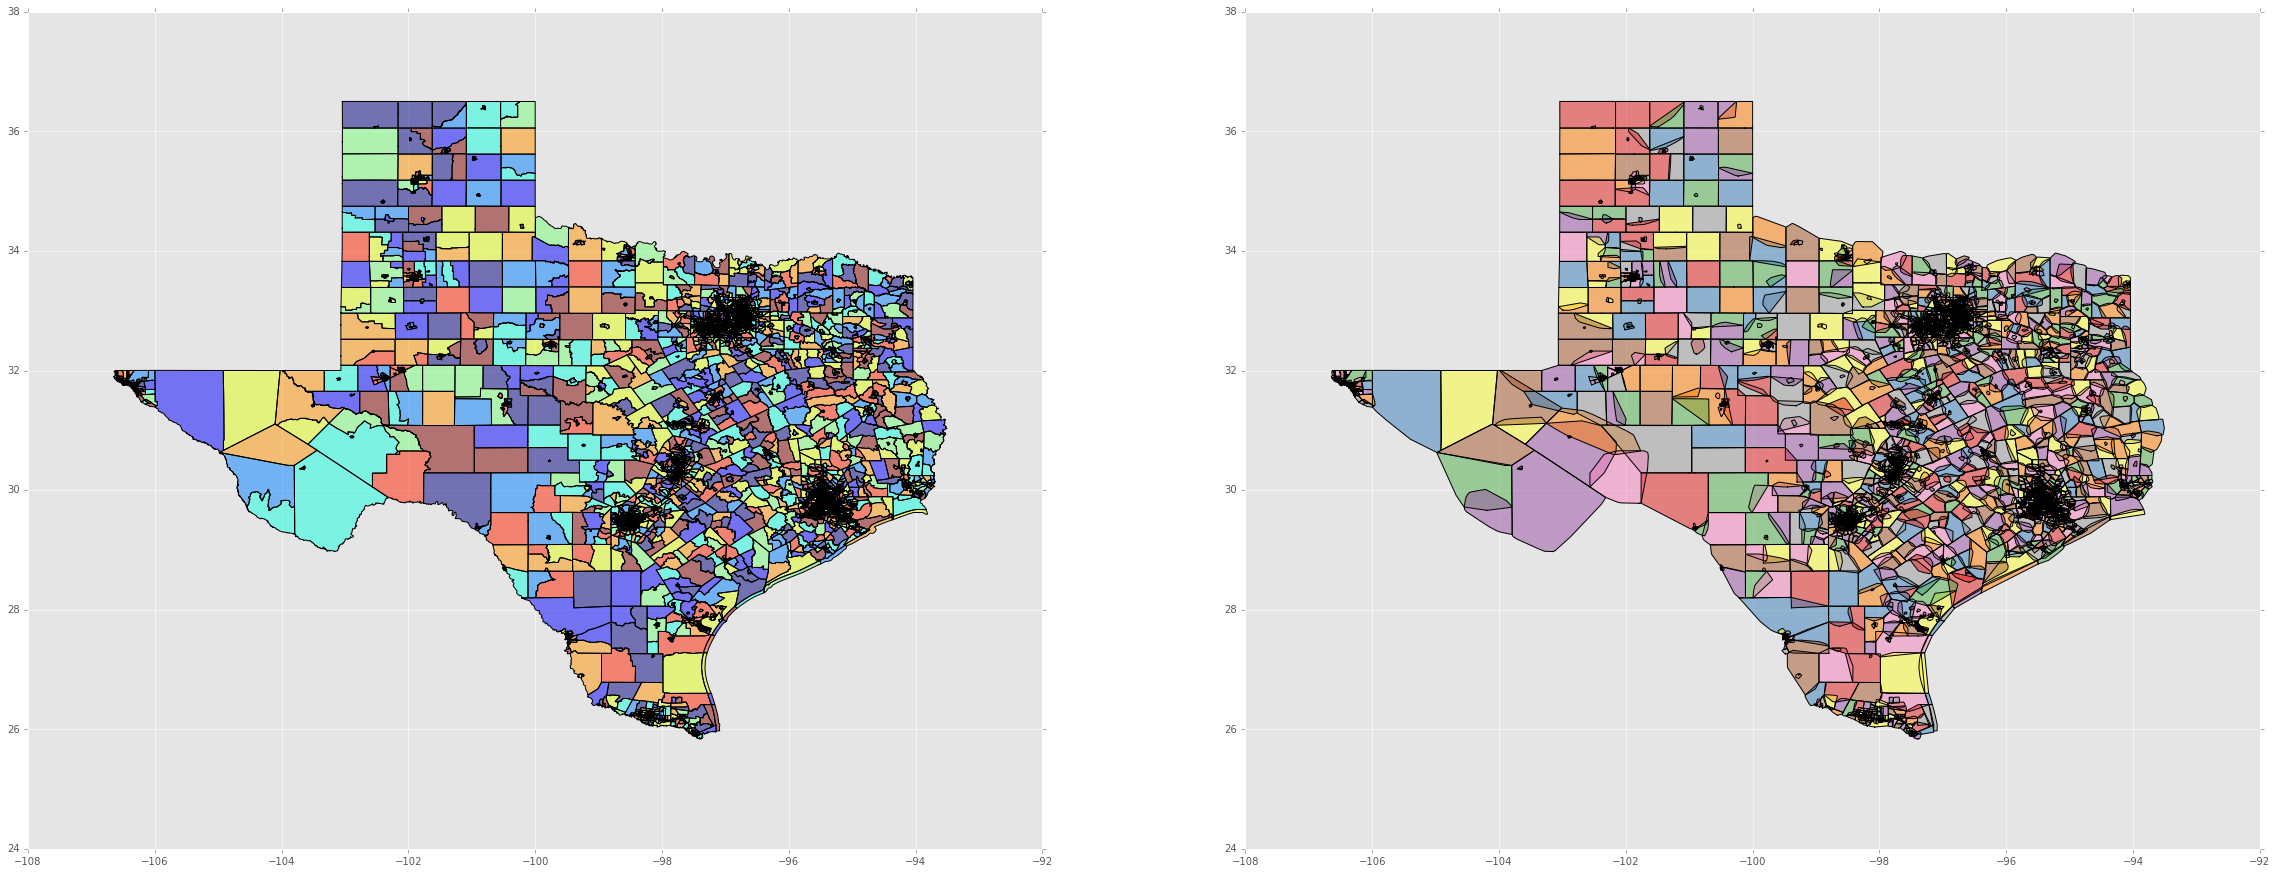

In [10]:
# As we can see that the GeoDataFrame automatically concocts the column geometry as the operating column
# Now let us perform some operation on it

fig, ax = plt.subplots(1,2,figsize=(40,15))
ax = ax.ravel()

# Plot the figure (Texax Map)
tl_2015.plot(ax=ax[0])

# plotting the convex_hull
convexhull = tl_2015['geometry'].convex_hull
convexhull.plot(ax=ax[1])

# What is convex hull.
# Mathematically, Convex hull is the small convex space touching all the outer points of a polygoan.
# For example : For points (0,1),(1,1), (1,2), (2,2), (4,0)    
# A polygoan would touch all the points and hence create a polygoan shape.
# A Convex hull would avoid the point (1,1) and directly connect (0,1) with (1,1). 
# Its because the point (1,1) would not lie at the surface of the polygoan when we connect all the points.
# Thats the reason we have many overlapping regions in the Texas map

# Geospatial Analysis: (Running an example) Advance Operations:
----------

For some advance operations lets bring out the Chicago Crime data and the shape Map of Chicago.

In [11]:
# Chicago Crime Data:
chicago_crm_pointsDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/Crimes2015_NA_rmv_sampl.csv'
chicagoCrime = pd.read_csv(chicago_crm_pointsDir)

# We see that there are two column Latitude and Longitude but, despite we converted out dataframe into a GeoDataFrame
# this column by itself are not treated as a geometry column. So we should tell GeoPandas to treat this
# column as the geometry column while performing geospatial analysis.

# First we convert/combine the column into GoeSeries (Point)
geoPoints = gpd.GeoSeries([shp.geometry.Point(long,lat) for lat,long in zip(chicagoCrime['Latitude'], chicagoCrime['Longitude'])])

# The points data is loaded, now as usual we should convert it into a GeoDataFrame
# So that we can perform all the awesome and relavant operations on it.
chicagoCrime = gpd.GeoDataFrame(chicagoCrime, geometry=geoPoints)

# Now that we have our dataset prepared, lets rename the geometry column to crimeGeoPoints
chicagoCrime = chicagoCrime.rename(columns={"geometry": "crimePoints_LatLon"}).set_geometry('crimePoints_LatLon')

chicagoCrime.head()

Unnamed: 0        ID Case.Number                    Date  \
0      227833  10323878    HY513662  11/15/2015 11:27:00 PM   
1      168966  10218533    HY404964  08/31/2015 05:21:00 PM   
2      138050  10162542    HY350931  07/22/2015 12:30:00 PM   
3      256354  10219461    HY398367  08/26/2015 03:30:00 PM   
4      101156  10096236    HY284755  05/29/2015 12:30:00 PM   

                   Block  IUCR     Primary.Type  \
0      064XX N DAMEN AVE  2826    OTHER OFFENSE   
1     029XX N CICERO AVE  1310  CRIMINAL DAMAGE   
2  064XX W FULLERTON AVE  0820            THEFT   
3     011XX W WILSON AVE  0820            THEFT   
4     002XX N KEELER AVE  0890            THEFT   

                      Description      Location.Description  Arrest  \
0  HARASSMENT BY ELECTRONIC MEANS                 APARTMENT   False   
1                     TO PROPERTY               GAS STATION   False   
2                  $500 AND UNDER             ATHLETIC CLUB   False   
3                  $500 AND UNDER                  SIDEWALK   False   
4                   FROM BUILDING  SCHOOL, PUBLIC, BUILDING   False   

                    ...                     Community.Area  FBI.Code  \
0                   ...                                  2        26   
1                   ...                                 19        14   
2                   ...                                 19        06   
3                   ...                                  3        06   
4                   ...                                 26        06   

   X.Coordinate  Y.Coordinate  Year              Updated.On   Latitude  \
0       1161794       1942800  2015  11/26/2015 03:54:17 PM  41.998718   
1       1143863       1919315  2015  09/10/2015 11:43:14 AM  41.934630   
2       1133118       1915251  2015  08/17/2015 03:03:40 PM  41.923673   
3       1167904       1930702  2015  04/15/2016 03:49:27 PM  41.965391   
4       1148358       1900901  2015  08/17/2015 03:03:40 PM  41.884014   

   Longitude                       Location  \
0 -87.680163  (41.998718085, -87.680162979)   
1 -87.746718  (41.934629749, -87.746717696)   
2 -87.786302  (41.923672617, -87.786301606)   
3 -87.658037  (41.965390764, -87.658037135)   
4 -87.730674  (41.884014312, -87.730673844)   

                        crimePoints_LatLon  
0       POINT (-87.680162979 41.998718085)  
1       POINT (-87.746717696 41.934629749)  
2  POINT (-87.78630160600001 41.923672617)  
3       POINT (-87.658037135 41.965390764)  
4  POINT (-87.73067384399999 41.884014312)  

[5 rows x 24 columns]

In [12]:
# Now we load the shape file of Chicago neighborhood/common areas/boundaries/etc...

# Since we directly load a shp file into the GeoDataFrame, GeoPandas 
# will automatically find the geometry column and treat it as such.

chicago_crm_shapeDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/Neighborhoods_2012/Neighborhoods_2012b.shp'
# chicago_crm_shapeDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/Buildings_20Boundaries/Buildings.shp'
chicagoShape = gpd.GeoDataFrame.from_file(chicago_crm_shapeDir)


# Now we rename the column into something understandable
chicagoShape = chicagoShape.rename(columns={"geometry": "chicagoShape_Merc"}).set_geometry('chicagoShape_Merc')
chicagoShape.head()

PRI_NEIGH           SEC_NEIGH    SHAPE_AREA     SHAPE_LEN  \
0     Grand Boulevard         BRONZEVILLE  4.849250e+07  28196.837157   
1        Printers Row        PRINTERS ROW  2.162138e+06   6864.247156   
2       United Center       UNITED CENTER  3.252051e+07  23101.363745   
3  Sheffield & DePaul  SHEFFIELD & DEPAUL  1.048259e+07  13227.049745   
4       Humboldt Park       HUMBOLDT PARK  1.250104e+08  46126.751351   

                                   chicagoShape_Merc  
0  POLYGON ((1182322.0429 1876674.730700001, 1182...  
1  POLYGON ((1176452.803199999 1897600.927599996,...  
2  POLYGON ((1165664.482500002 1902791.857299998,...  
3  POLYGON ((1167948.490499999 1914766.266999997,...  
4  POLYGON ((1145646.625 1902270.125100002, 11456...

#### Projection:
----------
When we look at our data, we see that the chicagoCrime data has point in **Latitude-Longitude** coordiante.projection system whereas the chicagoShape data is in **Mercetor** coordinate/projection system. We have to convert either of them so that we can plot them properly. Instead of doint that, why not add a new column with the other projection system.

In [13]:
def utm_to_latlon(lat, long):
    '''
        Input: Latitude and Longitude
        Output: Longitude and Latitude UTM projections 
    '''
    tup = utm.from_latlon(lat,long)
    lat_cnvrt = tup[0]
    long_cnvrt = tup[1]
    
    return long_cnvrt, lat_cnvrt

# utm_to_latlon(41.99871, -87.680163)
utmProjPoints = gpd.GeoSeries([shp.geometry.Point(utm_to_latlon(lat, long)) for lat,long in zip(chicagoCrime['Latitude'],chicagoCrime['Longitude'])])
chicagoCrime = gpd.GeoDataFrame(chicagoCrime,geometry=utmProjPoints)
chicagoCrime = chicagoCrime.rename(columns={'geometry':'crimePoints_Utm'}).set_geometry('crimePoints_Utm')
chicagoCrime.head()

Unnamed: 0        ID Case.Number                    Date  \
0      227833  10323878    HY513662  11/15/2015 11:27:00 PM   
1      168966  10218533    HY404964  08/31/2015 05:21:00 PM   
2      138050  10162542    HY350931  07/22/2015 12:30:00 PM   
3      256354  10219461    HY398367  08/26/2015 03:30:00 PM   
4      101156  10096236    HY284755  05/29/2015 12:30:00 PM   

                   Block  IUCR     Primary.Type  \
0      064XX N DAMEN AVE  2826    OTHER OFFENSE   
1     029XX N CICERO AVE  1310  CRIMINAL DAMAGE   
2  064XX W FULLERTON AVE  0820            THEFT   
3     011XX W WILSON AVE  0820            THEFT   
4     002XX N KEELER AVE  0890            THEFT   

                      Description      Location.Description  Arrest  \
0  HARASSMENT BY ELECTRONIC MEANS                 APARTMENT   False   
1                     TO PROPERTY               GAS STATION   False   
2                  $500 AND UNDER             ATHLETIC CLUB   False   
3                  $500 AND UNDER                  SIDEWALK   False   
4                   FROM BUILDING  SCHOOL, PUBLIC, BUILDING   False   

                      ...                       FBI.Code  X.Coordinate  \
0                     ...                             26       1161794   
1                     ...                             14       1143863   
2                     ...                             06       1133118   
3                     ...                             06       1167904   
4                     ...                             06       1148358   

   Y.Coordinate  Year              Updated.On   Latitude  Longitude  \
0       1942800  2015  11/26/2015 03:54:17 PM  41.998718 -87.680163   
1       1919315  2015  09/10/2015 11:43:14 AM  41.934630 -87.746718   
2       1915251  2015  08/17/2015 03:03:40 PM  41.923673 -87.786302   
3       1930702  2015  04/15/2016 03:49:27 PM  41.965391 -87.658037   
4       1900901  2015  08/17/2015 03:03:40 PM  41.884014 -87.730674   

                        Location                       crimePoints_LatLon  \
0  (41.998718085, -87.680162979)       POINT (-87.680162979 41.998718085)   
1  (41.934629749, -87.746717696)       POINT (-87.746717696 41.934629749)   
2  (41.923672617, -87.786301606)  POINT (-87.78630160600001 41.923672617)   
3  (41.965390764, -87.658037135)       POINT (-87.658037135 41.965390764)   
4  (41.884014312, -87.730673844)  POINT (-87.73067384399999 41.884014312)   

                               crimePoints_Utm  
0  POINT (4649857.621612935 443669.2483944244)  
1  POINT (4642787.870839979 438095.1726599361)  
2  POINT (4641600.656321065 434802.3855430915)  
3  POINT (4646142.993461905 445473.2803646126)  
4  POINT (4637156.675222915 439377.3848248574)  

[5 rows x 25 columns]

In [34]:
#########  For Lat Long Data
# Converting the Latitude and Longitude into Mercator projection
crimeLatLon = chicagoCrime['crimePoints_LatLon']
crimeLatLon.crs = {'init': 'epsg:4326'}  # Setting the column to LatLong CRS
mercProjPoints = crimeLatLon.to_crs({'init': 'epsg:3857'})  # 3395 creating a new column with Mercetor projection
chicagoCrime = gpd.GeoDataFrame(chicagoCrime, geometry=mercProjPoints)

# We reset the geometry to LatLon 
chicagoCrime = chicagoCrime.rename(columns={'geometry':'crimePoints_Merc'}).set_geometry('crimePoints_Merc')
chicagoCrime.head()

AttributeError: 'Series' object has no attribute 'to_crs'

In [16]:
#########  For Shape Data
shapeMerc = chicagoShape['chicagoShape_Merc']
shapeMerc.crs = {'init': 'epsg:3395'}  # Setting the column to Mercator CRS
latlonCoordPoints = shapeMerc.to_crs({'init': 'epsg:4326'})  # creating a new column with LatLon coordinates
chicagoShape = gpd.GeoDataFrame(chicagoShape, geometry=latlonCoordPoints)

# We reset the geometry to LatLon 
chicagoShape = chicagoShape.rename(columns={'geometry':'chicagoShape_LatLon'}).set_geometry('chicagoShape_Merc')
chicagoShape.head(5)

PRI_NEIGH           SEC_NEIGH    SHAPE_AREA     SHAPE_LEN  \
0     Grand Boulevard         BRONZEVILLE  4.849250e+07  28196.837157   
1        Printers Row        PRINTERS ROW  2.162138e+06   6864.247156   
2       United Center       UNITED CENTER  3.252051e+07  23101.363745   
3  Sheffield & DePaul  SHEFFIELD & DEPAUL  1.048259e+07  13227.049745   
4       Humboldt Park       HUMBOLDT PARK  1.250104e+08  46126.751351   

                                   chicagoShape_Merc  \
0  POLYGON ((1182322.0429 1876674.730700001, 1182...   
1  POLYGON ((1176452.803199999 1897600.927599996,...   
2  POLYGON ((1165664.482500002 1902791.857299998,...   
3  POLYGON ((1167948.490499999 1914766.266999997,...   
4  POLYGON ((1145646.625 1902270.125100002, 11456...   

                                 chicagoShape_LatLon  \
0  POLYGON ((10.62097961888486 16.72610544888656,...   
1  POLYGON ((10.56825534159815 16.90716081237297,...   
2  POLYGON ((10.47134220785024 16.95204604972071,...   
3  POLYGON ((10.49185980080473 17.05554566978137,...   
4  POLYGON ((10.29151873437446 16.94753519483652,...   

                                 chicagoShape_LatLon  
0  POLYGON ((10.62097961888486 16.72610544888656,...  
1  POLYGON ((10.56825534159815 16.90716081237297,...  
2  POLYGON ((10.47134220785024 16.95204604972071,...  
3  POLYGON ((10.49185980080473 17.05554566978137,...  
4  POLYGON ((10.29151873437446 16.94753519483652,...

#### Initial Plot:

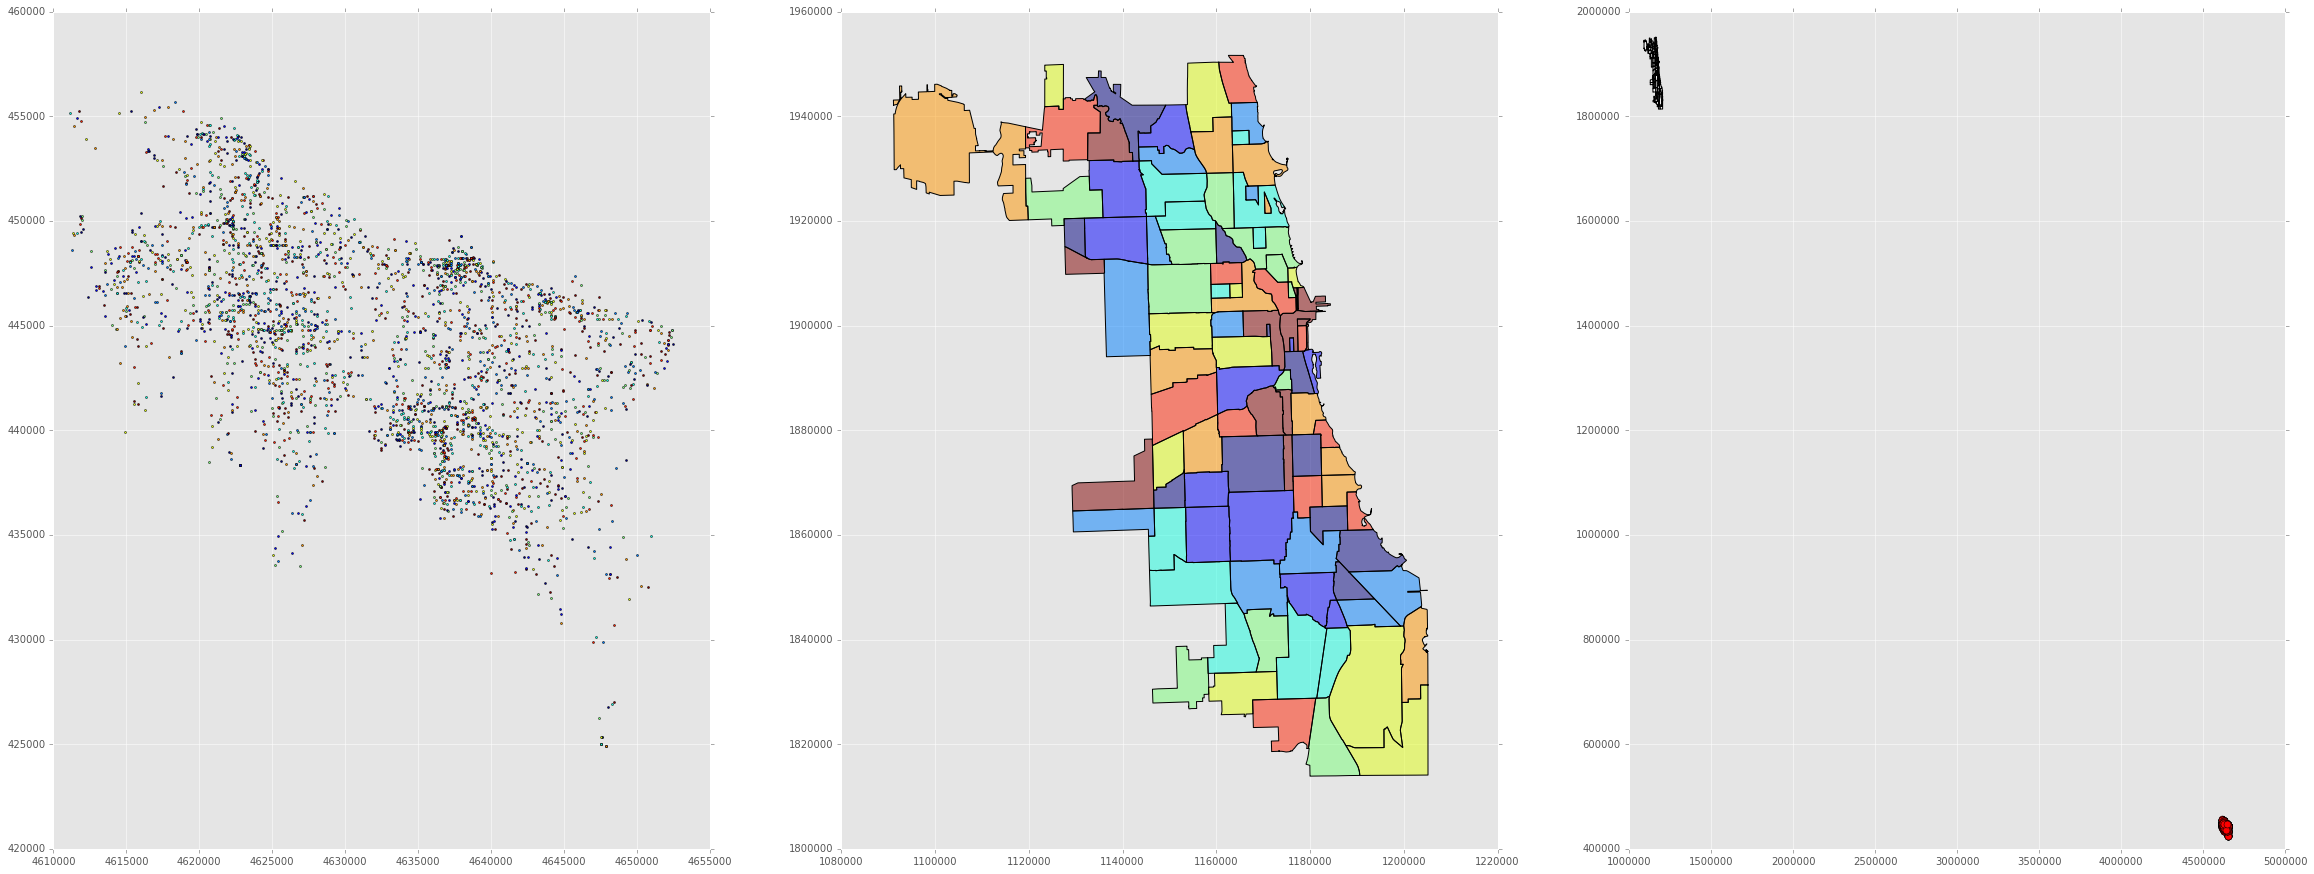

In [17]:
fig, ax = plt.subplots(1,3, figsize=(40,15))
ax = ax.ravel()

# Plot1:
chicagoCrime.plot(ax=ax[0])

# Plot2:
chicagoShape.plot(ax=ax[1])

# We define our base plot to be the shape plots
basePlot = chicagoShape.plot(ax=ax[2], color='white')
chicagoCrime.plot(ax=basePlot, marker='o', color='red', markersize=7);

## Operations:
---------

#### Draw a circle with fixed radius around each point:

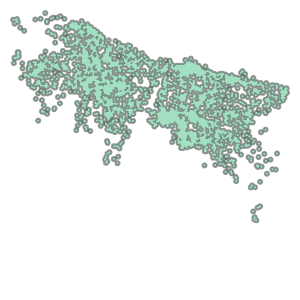

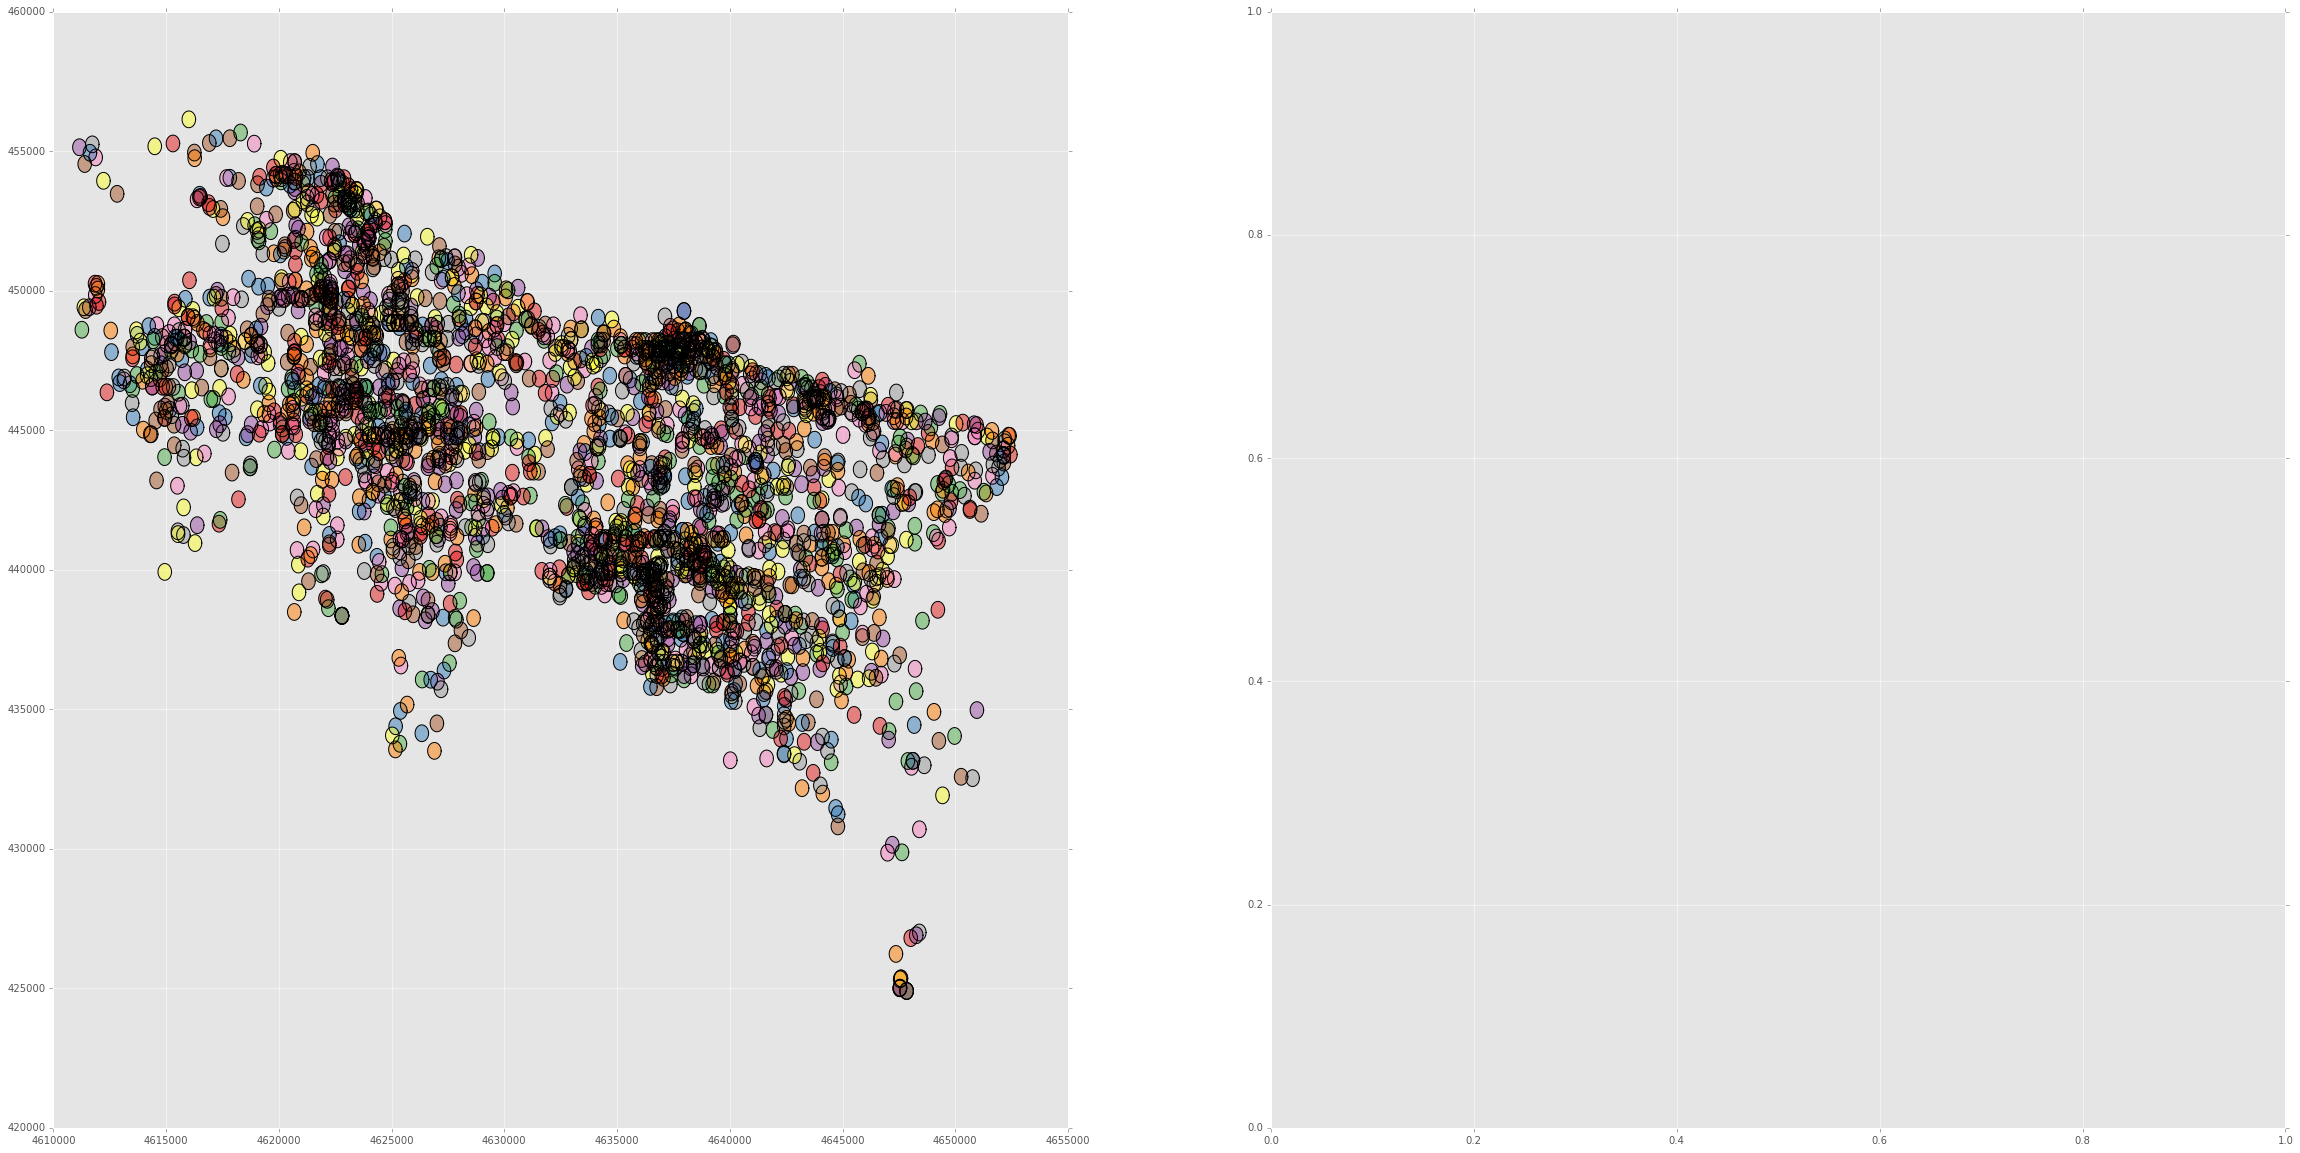

In [18]:
fig, ax = plt.subplots(1,2, figsize=(40,20))
ax = ax.ravel()

# We have all the points or rather Crime Points, now we convert these points into larger circle.
# This plot can come in handy to build small intersection between closeby points.
circles = chicagoCrime['crimePoints_Utm'].buffer(300)   # Buffer is some what like how 
circles.plot(ax=ax[0])

# Now we should try collapsing these circles, As expected these would create multipolygon points
# Since we are trying to combine points, so we need to have multiple points building polygoans (curve multiple circles)

### Can be thought of dissolving the geometry of intersecting circles.
multiPolygons = circles.unary_union
multiPolygons


#### Overlay Functions:

/Users/sam/App-Setup/CondaENV/lib/python3.5/site-packages/geopandas/base.py:73: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")


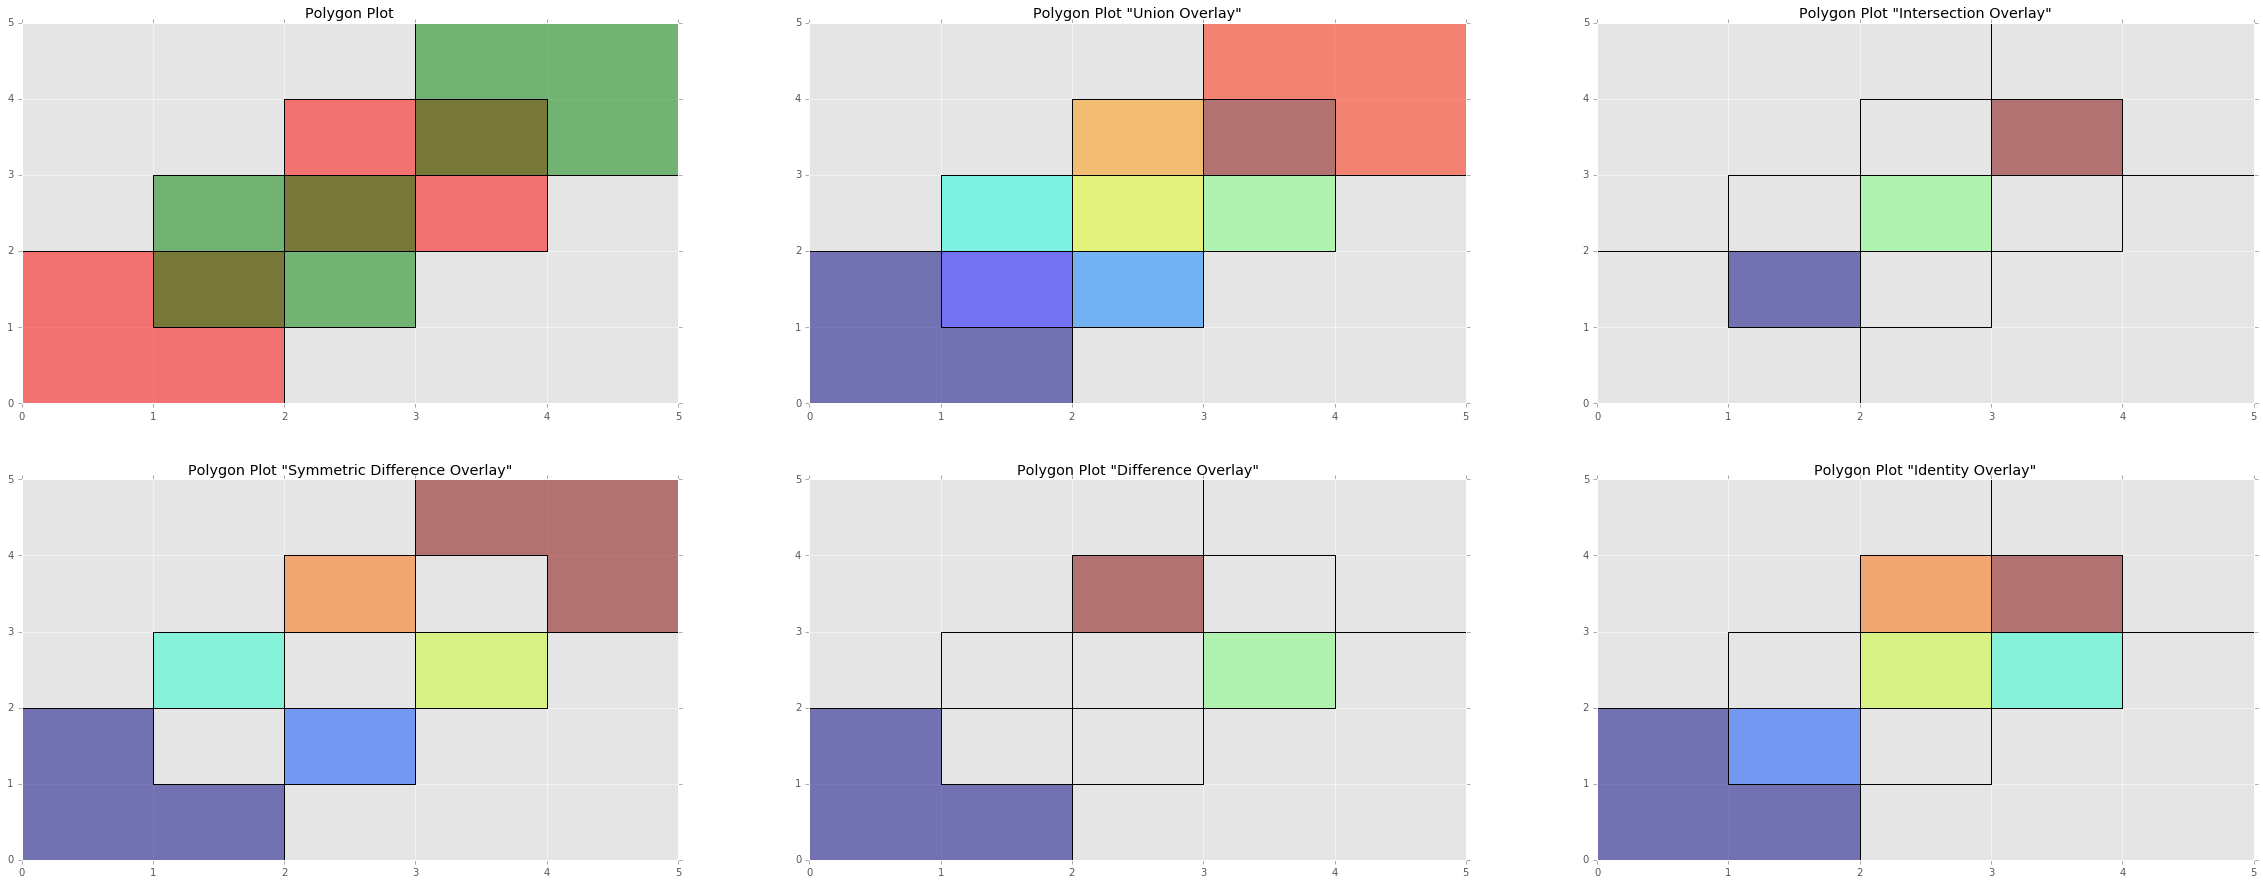

In [19]:
from shapely.geometry import Polygon

fig, ax = plt.subplots(2,3, figsize=(40,15))
ax = ax.ravel()

# Create a GeoSeries if Polygons
plgn1 = gpd.GeoSeries([Polygon([(0,0),(2,0),(2,2), (0,2)]),
                       Polygon([(2,2), (4,2), (4,4), (2,4)])
                      ])
plgn2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                       Polygon([(3,3), (5,3), (5,5), (3,5)])
                      ])

# Create a GeoDataFrame
plgn1_DF = gpd.GeoDataFrame({'geometry': plgn1, 'indices' : [1,2]})
plgn2_DF = gpd.GeoDataFrame({'geometry': plgn2, 'indices' : [1,2]})

# Plotting the Points
plgn1_plot = plgn1_DF.plot(ax = ax[0], color='red')
plgn2_DF.plot(ax=plgn1_plot, color='green')
ax[0].set_title('Polygon Plot')


# Find all the Layover points/Build separate polygons for each 
# and then plot each polygons

## Union overlay
union_overlay = gpd.overlay(plgn1_DF, plgn2_DF, how='union')
# union_overlay
union_overlay.plot(ax = ax[1])
plgn1_DF.plot(ax=ax[1], facecolor='none');
plgn2_DF.plot(ax=ax[1], facecolor='none');
ax[1].set_title('Polygon Plot "Union Overlay"')


## Intersection overlay
intersection_overlay = gpd.overlay(plgn1_DF, plgn2_DF, how='intersection')
intersection_overlay.plot(ax = ax[2])
plgn1_DF.plot(ax=ax[2], facecolor='none');
plgn2_DF.plot(ax=ax[2], facecolor='none');
ax[2].set_title('Polygon Plot "Intersection Overlay"')


## Symmetric Difference (evrything but intersection)
syndiff_overlay = gpd.overlay(plgn1_DF, plgn2_DF, how='symmetric_difference')
syndiff_overlay.plot(ax = ax[3])
plgn1_DF.plot(ax=ax[3], facecolor='none');
plgn2_DF.plot(ax=ax[3], facecolor='none');
ax[3].set_title('Polygon Plot "Symmetric Difference Overlay"')

## Difference (Geometry contained in plgn1_DF but not in plgn2_DF)
diff_overlay = gpd.overlay(plgn1_DF, plgn2_DF, how='difference')
diff_overlay.plot(ax = ax[4])
plgn1_DF.plot(ax=ax[4], facecolor='none');
plgn2_DF.plot(ax=ax[4], facecolor='none');
ax[4].set_title('Polygon Plot "Difference Overlay"')

## Identity (Cover all the shapes covered in plgn1_DF, but from plgn2_DF cover only those that intersect with plgn1_DF)
identity_overlay = gpd.overlay(plgn1_DF, plgn2_DF, how='identity')
identity_overlay.plot(ax = ax[5])
plgn1_DF.plot(ax=ax[5], facecolor='none');
plgn2_DF.plot(ax=ax[5], facecolor='none');
ax[5].set_title('Polygon Plot "Identity Overlay"')

#### Aggregation Operation (Dissolve):

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove all unwanted columns
world = world[['continent', 'geometry', 'pop_est']]
world.head(20)

continent  \
0                      Asia   
1                    Africa   
2                    Europe   
3                      Asia   
4             South America   
5                      Asia   
6                Antarctica   
7   Seven seas (open ocean)   
8                   Oceania   
9                    Europe   
10                     Asia   
11                   Africa   
12                   Europe   
13                   Africa   
14                   Africa   
15                     Asia   
16                   Europe   
17            North America   
18                   Europe   
19                   Europe   

                                             geometry      pop_est  
0   POLYGON ((61.21081709172574 35.65007233330923,...   28400000.0  
1   (POLYGON ((16.32652835456705 -5.87747039146621...   12799293.0  
2   POLYGON ((20.59024743010491 41.85540416113361,...    3639453.0  
3   POLYGON ((51.57951867046327 24.24549713795111,...    4798491.0  
4   (POLYGON ((-65.50000000000003 -55.199999999999...   40913584.0  
5   POLYGON ((43.58274580259273 41.09214325618257,...    2967004.0  
6   (POLYGON ((-59.57209469261153 -80.040178725096...       3802.0  
7   POLYGON ((68.935 -48.62500000000001, 69.58 -48...        140.0  
8   (POLYGON ((145.3979781434948 -40.7925485166058...   21262641.0  
9   POLYGON ((16.97966678230404 48.12349701597631,...    8210281.0  
10  (POLYGON ((45.0019873390568 39.7400035670496, ...    8238672.0  
11  POLYGON ((29.33999759290035 -4.499983412294092...    8988091.0  
12  POLYGON ((3.314971144228537 51.34578095153609,...   10414336.0  
13  POLYGON ((2.691701694356254 6.258817246928629,...    8791832.0  
14  POLYGON ((-2.827496303712707 9.642460842319778...   15746232.0  
15  POLYGON ((92.67272098182556 22.04123891854125,...  156050883.0  
16  POLYGON ((22.65714969248299 44.23492300066128,...    7204687.0  
17  (POLYGON ((-77.53465999999997 23.7597499999999...     309156.0  
18  POLYGON ((19.00548628101012 44.86023366960916,...    4613414.0  
19  POLYGON ((23.48412763844985 53.91249766704114,...    9648533.0

(8, 2)
(8, 2)


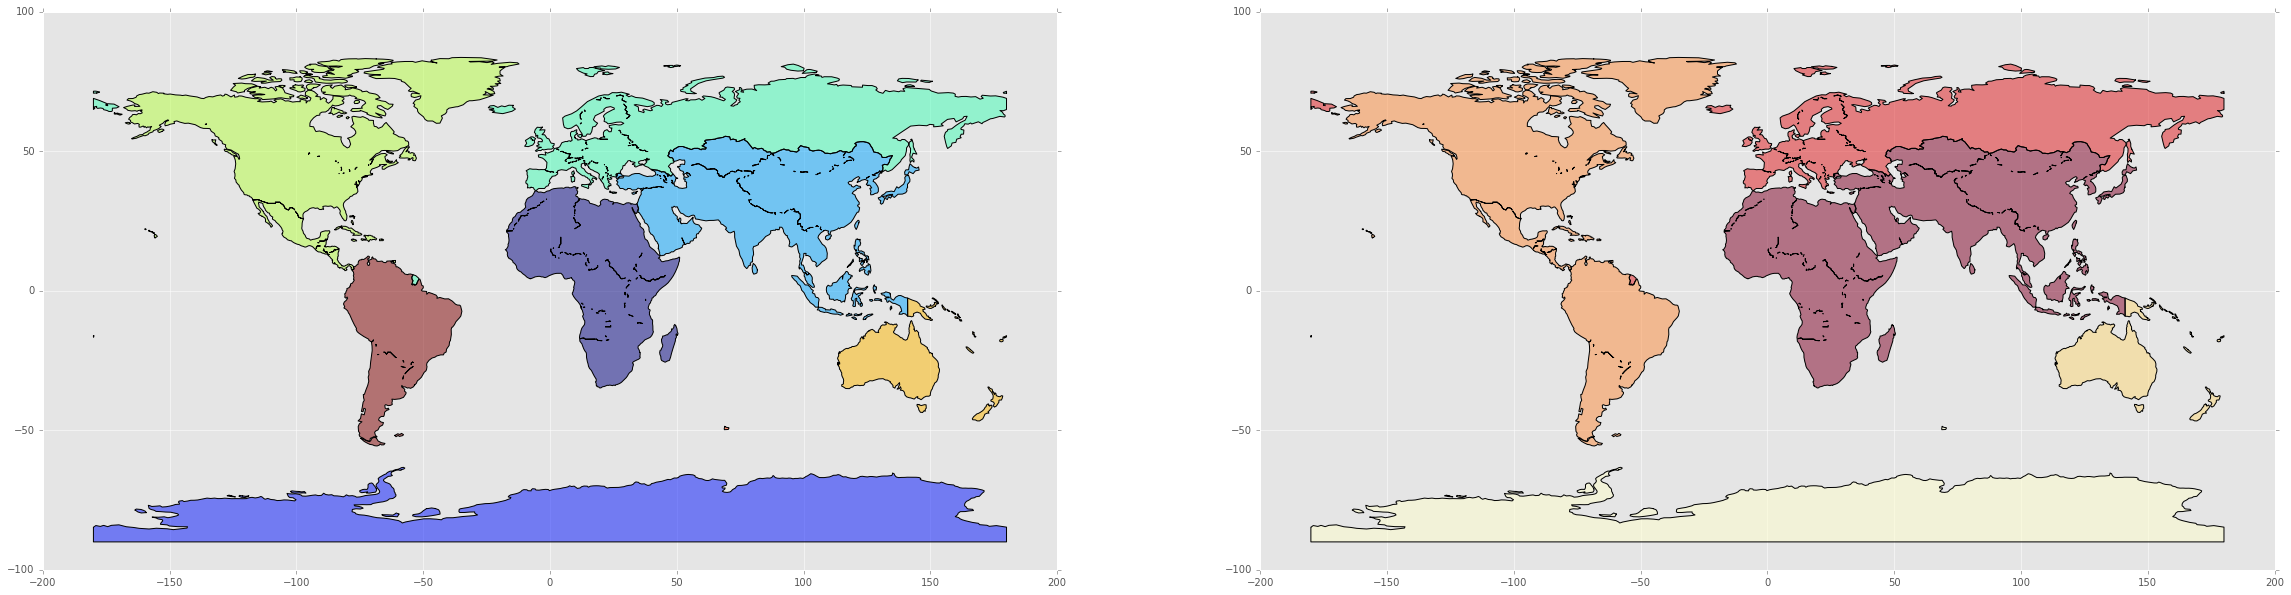

In [21]:
fig, ax = plt.subplots(1,2, figsize=(40,10))
ax = ax.ravel()

## Scenario1: We see that the above data could be country based or area based or whatever,
# Since there are multiply entries for each continent, we would like to combine them into one
# This can be done by using the dissolve command, which combines all the entries with the same continent name
continents = world.dissolve(by='continent')
continents.plot(ax=ax[0])
print (continents.shape)  # We have only 8 entries which says 

## Scenario2: Now that we see that "dissolve" works like a charm to aggregate "geometries", 
# how about, if we want to aggregate the population column, For Example: a SQL statement such as,
# select sum(pop_est), continent, dissolve(geometry) from world group by continent
# We can do this using by the same trick with a small change.
continents = world.dissolve(by='continent', aggfunc='sum')  # GeoPandas automatically understnds that we are taking abou the pop_est column
continents.plot(ax=ax[1], column = 'pop_est', scheme='quantiles', cmap='YlOrRd') # The colors are provided based on the 
# column population estimate, by dividing the total population into 4 parts, where Asia and Africa falls under the top quantile
print (continents.shape)

In [22]:
continents.head()  # All the population estimatas are added

geometry       pop_est
continent                                                                     
Africa         (POLYGON ((49.54351891459575 -12.4698328589405...  9.932819e+08
Antarctica     (POLYGON ((-159.2081835601977 -79.497059421708...  3.802000e+03
Asia           (POLYGON ((120.7156087586305 -10.2395813940878...  4.085853e+09
Europe         (POLYGON ((-52.55642473001839 2.50470530843705...  7.281312e+08
North America  (POLYGON ((-61.68000000000001 10.76, -61.105 1...  5.393510e+08

### Merging and Joins:
--------

Two types of join 1) Attribute Join and 2) Spatial join. 

* Attribute join: A GeoSeries or GeoDataFrame are joined to a regular Data Frame
* Spatial Joins: Observations from GeoSeries or GeoDataFrame are combined based on their spatial relationship to one another.

In [23]:
# What we do is, we ge the DataFrame from GeoPandas, break the dataframe into sevral small 
# dataframes and then merge them into the original Data Frame.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Extracting each country 
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]

# Get the ciuntry name from the world map just like we do in pandas
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})

In [24]:
country_shapes.head()

geometry iso_a3
0  POLYGON ((61.21081709172574 35.65007233330923,...    AFG
1  (POLYGON ((16.32652835456705 -5.87747039146621...    AGO
2  POLYGON ((20.59024743010491 41.85540416113361,...    ALB
3  POLYGON ((51.57951867046327 24.24549713795111,...    ARE
4  (POLYGON ((-65.50000000000003 -55.199999999999...    ARG

In [25]:
country_names.head()

name iso_a3
0           Afghanistan    AFG
1                Angola    AGO
2               Albania    ALB
3  United Arab Emirates    ARE
4             Argentina    ARG

#### Attribute Join (MERGE):

In [26]:
country_shapes = country_shapes.merge(country_names, on='iso_a3')
country_shapes.head()

geometry iso_a3  \
0  POLYGON ((61.21081709172574 35.65007233330923,...    AFG   
1  (POLYGON ((16.32652835456705 -5.87747039146621...    AGO   
2  POLYGON ((20.59024743010491 41.85540416113361,...    ALB   
3  POLYGON ((51.57951867046327 24.24549713795111,...    ARE   
4  (POLYGON ((-65.50000000000003 -55.199999999999...    ARG   

                   name  
0           Afghanistan  
1                Angola  
2               Albania  
3  United Arab Emirates  
4             Argentina

#### Spatial Join (JOIN):

In [27]:
print (countries.shape)
countries.head()

(177, 2)


geometry               country
0  POLYGON ((61.21081709172574 35.65007233330923,...           Afghanistan
1  (POLYGON ((16.32652835456705 -5.87747039146621...                Angola
2  POLYGON ((20.59024743010491 41.85540416113361,...               Albania
3  POLYGON ((51.57951867046327 24.24549713795111,...  United Arab Emirates
4  (POLYGON ((-65.50000000000003 -55.199999999999...             Argentina

In [28]:
print (cities.shape)
cities.head()

(202, 2)


geometry          name
0  POINT (12.45338654497177 41.90328217996012)  Vatican City
1    POINT (12.44177015780014 43.936095834768)    San Marino
2  POINT (9.516669472907267 47.13372377429357)         Vaduz
3  POINT (6.130002806227083 49.61166037912108)    Luxembourg
4  POINT (158.1499743237623 6.916643696007725)       Palikir

In [29]:
# This might seem rather interesting as the there is nothing common in both the country and cities Dataframe to join. 
# Moreover the geometry of countries is polygon and cities is points.

# This is the actual speciality, when performing spatial joins between Points and Polygons, we use the intersection operarion.
# This joins the record based on if the Point is inside the Polygon, or rather if the Point intersect any of the Point inside the
# Polygon
cities_with_country = gpd.sjoin(cities, countries, how="inner", op='intersects')
cities_with_country.head()

ImportError: No module named 'rtree'